In [ ]:
# Import necessary libraries
!pip install ipympl
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

## Scenario

The Multi-Armed Bandit describes a situation in which an agent has only one state, and multiple actions to interact with the environment. Each action gives a random reward, centered on an unkown value. Our agent wants to maximize the reward received, which means it wants to find the action that yields a higher reward. Based on this, let's build the scenario.

We're going to implement the multi-armed bandit environment. Also, our implementation will be vectorized for the sake of optimization. This allows us to run multiple agents on multiple environments at the same time. The code below is based on [this implementation](https://github.com/diegoalejogm/openai-k-armed-bandits)

In [3]:
class ArmedBanditsEnv():
    """
    The k-Armed Bandit Environment
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """

    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2

        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]

        self.mean = mean
        self.stddev = stddev

    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()

        sampled_means = self.mean[np.arange(self.num_experiments),action]
        sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]

        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs, size=(1,self.num_experiments))

        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]

    def close(self):
        pass


class ArmedBanditsGaussian(ArmedBanditsEnv):
    def __init__(self, num_experiments=1, num_bandits=3):
        self.means = np.random.normal(size=(num_experiments, num_bandits))

        ArmedBanditsEnv.__init__(self, self.means, np.ones((num_experiments, num_bandits)))

Here we're creating two classes, `ArmedBanditsEnv` is the main class, while `ArmedBanditsGaussian` is an auxiliary class that allows us to easily create an environment with random mean rewards for each action. Our environment receives numpy arrays for the means and standard deviations for each action. The dimensions of this arrays are described as `num_experiments`x`num_bandits`. Taking a step requires a numpy vector of size `num_experiments`, where each value specifies which action to take for each experiment. The step functions returns, among other information, a vector of reward obtained for each experiment. Let's see this in action:

In [4]:
means = np.array([[5, 1, 0, -10]]) # The mean for a four-armed bandit. Single experiment
stdev = np.array([[1, 0.1, 5, 1]]) # The standard deviation for a four-armed bandit.

env = ArmedBanditsEnv(means, stdev) # Create the environment

for i in range(4):
    action = np.array([[i]])
    _, reward, _, _ = env.step(action)
    print("Bandit:", i, " gave a reward of:", reward[0])

Bandit: 0  gave a reward of: [3.91778725]
Bandit: 1  gave a reward of: [1.02209704]
Bandit: 2  gave a reward of: [-4.35425515]
Bandit: 3  gave a reward of: [-12.03230158]


In order to learn something from our interaction with the environment, we need to know how exactly we determine the value of our actions, as well as how to keep that value up to date. A simple strategy our agents can take is to calculate the expected return for each action. This can be done through experience by taking the average of previous rewards given by a determined action.

For example, we can use the next list of rewards to calculate the expected return of the chosen action:

$\bar{\mu}_t = \dfrac{R_1+R_2+\dots+R_t}{t}$

Having to store all the previously seen rewards to calculate the value of an action is cumbersome, inefficient and unnecessary. We can derive another form of average, called *Incremental average update rule*, which only requires us to know the previous average $\bar{\mu}_{t-1}$ and the number $t$:

$\bar{\mu}_t = \bar{\mu}_{t-1} + \dfrac{1}{t}(R_t - \bar{\mu}_{t-1})$

Here's a small demonstration of this function at work

In [5]:
def inc_avg(prev_avg, new_val, n):
    return prev_avg + 1/n*(new_val - prev_avg)

# Obtain the previous average
vals = np.array([4.5, 5.04, 5.32, 4.8, 5.11])
prev_avg = vals.mean()

# Calculate a new average using the incremental average update function
new_val = 5.18
new_avg = inc_avg(prev_avg, new_val, 6)

# Calculate the same average using all previous values for comparison
avg = np.append(vals, new_val).mean()

print("Average obtained from incremental update rule: ", new_avg)
print("Average obtained from basic average function:  ", avg)

Average obtained from incremental update rule:  4.991666666666666
Average obtained from basic average function:   4.991666666666666


This method will be used on the next strategies

## The Greedy Agent

This strategy is focused on always choosing the best known action at the time. Every time the agent takes an action, it looks at the estimated values for each action, and chooses the one that has a greater score. If more than two values look best, then the agent selects arbitrarily among those best-valued actions. This is called breaking ties arbitrarily

Taking the action with the greatest value is equivalent to using the **argmax** function. Although, we need to implement some changes so that the funciton breaks the ties the way we intend it to do:

In [6]:
def argmax(q_values):
    """
    Takes in a matrix of n*k q_values and returns the index
    of the item with the highest value for each row.
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of
    the highest value in q_values for each row.
    """
    # Generate a mask of the max values for each row
    mask = q_values == q_values.max(axis=1)[:, None]
    # Generate noise to be added to the ties
    r_noise = 1e-6*np.random.random(q_values.shape)
    # Get the argmax of the noisy masked values
    return np.argmax(r_noise*mask,axis=1)

Here we're generating a mask of all the values in the input that are equal to the maximum value. Then ,we generate some noise and multiply it with the mask. Taking the argmax of this new list will be equivalent to the desired argmax with ties broken arbitrarily.

Now that we have specified the argmax function, we can declare our class for the Greedy Agent, which is capable of acting upon the environment, and updating its estimates after receiving a reward.

In [7]:
class GreedyAgent:
    def __init__(self, reward_estimates):
        """
        Our agent takes as input the initial reward estimates.
        This estimates will be updated incrementally after each
        interaction with the environment.
        """
        assert len(reward_estimates.shape) == 2

        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)

    def get_action(self):
        # Our agent is greedy, so there's no need for exploration.
        # Our argmax will do just fine for this situation
        action = argmax(self.reward_estimates)

        # Add a 1 to each action selected in the action count
        self.action_count[np.arange(self.num_experiments), action] += 1

        return action

    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        prev_reward_estimates = self.reward_estimates[np.arange(self.num_experiments), action]

        # Update the reward estimates incementally
        self.reward_estimates[np.arange(self.num_experiments), action] = inc_avg(prev_reward_estimates,reward,n)

The greedy agent contains a matrix for the estimates, as well as for the number of times each action has been taken. This is necessary for using the incremental average update rule, used inside the `update_estimates` function.

### Testing the agent

Let's see how the Greedy Agent behaves on the environment. For this, we're going to generate some animations where we're able to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information.

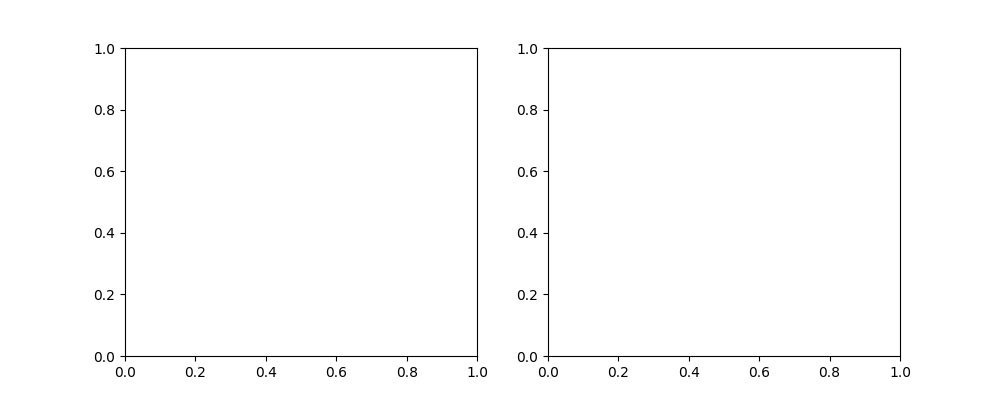

In [15]:
from google.colab import output
output.enable_custom_widget_manager()

# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments,num_bandits)))

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)

def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()
anim.save('greedy-agent.gif', writer='pillow', fps=60)

We can plot the average behavior by doing more experiments. The next plot displays the percentage of times the agent chose the optimal action over an average of 10000 experiments.

100%|██████████| 1000/1000 [00:10<00:00, 99.67it/s]


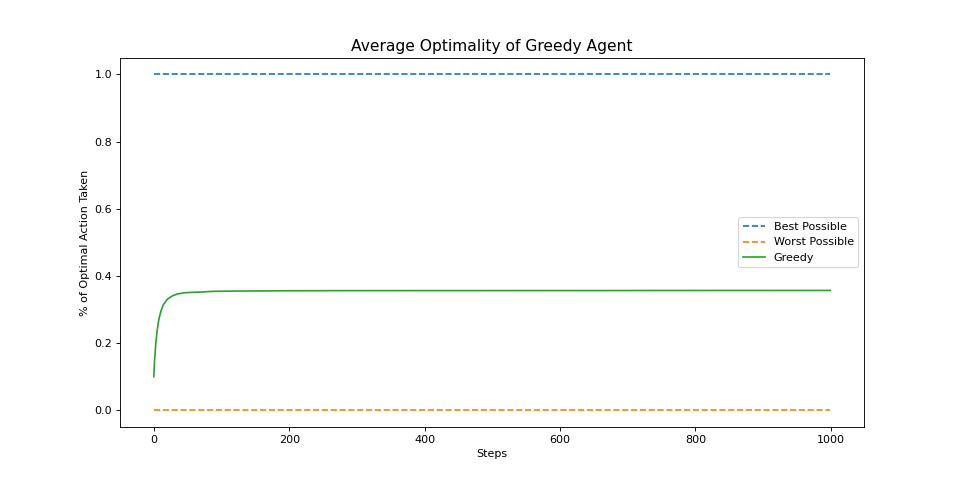

In [16]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)

    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)

    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score

    # Get optimal actions from the environment
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

The Greedy Agent chooses the best action on average ~40% of the times. Additionally, extra experience won't improve it's score, as it usually lands on a sub-optimal action on the first steps, and stays there for ever. The Greedy Agent is not a good strategy for finding the optimal action on this scenario.

## The Epsilon-Greedy Agent

Another strategy is the Epsilon Greedy Agent, which adds to the previous strategy. An Epsilon-Greedy Agent allows for some exploratory actions, by every once in a while choosing any action randomly, instead of always acting greedily. The probability of taking an exploratory action is defined by the parameter `epsilon`. An epsilon of `0` is a Greedy Agent. An epsilon of `0.2` means our agent takes a random action 20% of the time. An epsilon of `1` is an agent that behaves randomly. Let's build this new agent

In [19]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon

    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability

        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)

        self.action_count[np.arange(self.num_experiments), action] += 1

        return action

As may be seen, we're inheriting the `GreedyAgent` implementation, and only changing the `get_action` function. For taking an action, we're using a masking that defines which experiments will choose an action randomly and which will act greedily. Then, we apply that masking between random and greedy actions to obtain the action vector for all of our experiments.

### Testing the Agent

Here, we're going to use the same animation as before to observe how this new strategy behaves. Our agents will have a value of epsilon of `0.1`

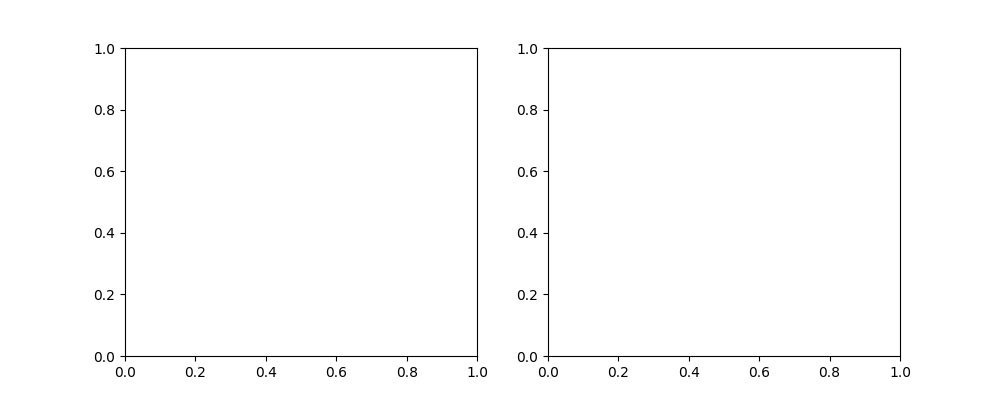

In [27]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 0.1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)


def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()
anim.save('epsilon-greedy-agent.gif', writer='pillow', fps=60)

Again, you may run the previous block multiple times to see different runs. As can be observed, the epsilon-greedy agent not only finds the optimal solution most of the times, but it is also capable of finding close estimated values for all the actions! Observe how the new strategy compares to the greedy agent on average.

In [24]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))

    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)

    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)

        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)

        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score

        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:05<00:00, 171.40it/s]


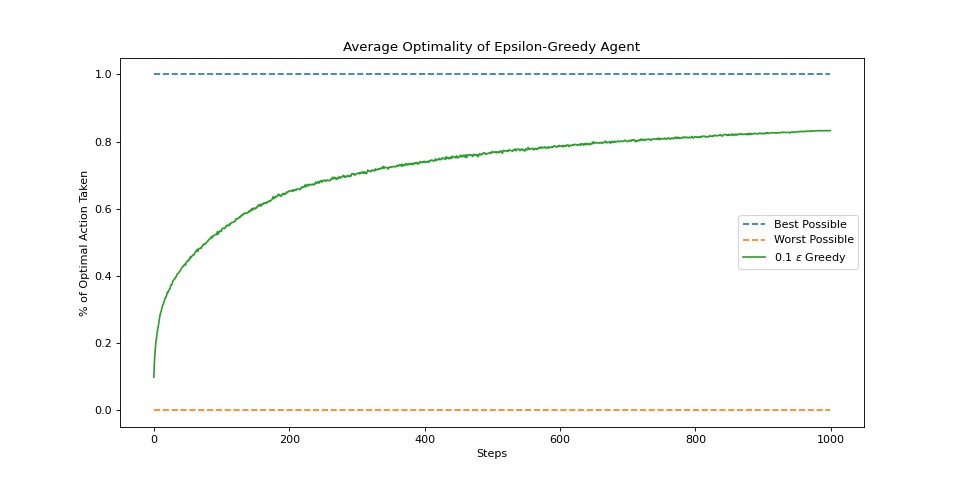

In [37]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 $\epsilon$ Greedy"])
plt.title("Average Optimality of Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

After 1000 steps, the Epsilon-Greedy Agent is capable of reaching an 80% average optimality. This means that on average, they choose the best possible action 80% of the times after that amount of iterations. We can also see how our agent is capable of improving from experience, contrary to the Greedy Agent.

## Values for epsilon

On the previous example, we used a value for `epsilon` of `0.1`. This means that the agent chose an exploratory action 10% of the times. Like with almost all hyper-parameters in Machine Learning, there's a range of values which behave better than others. Let's make an actual experiment using different values for `epsilon`

100%|██████████| 1000/1000 [00:00<00:00, 1442.66it/s]


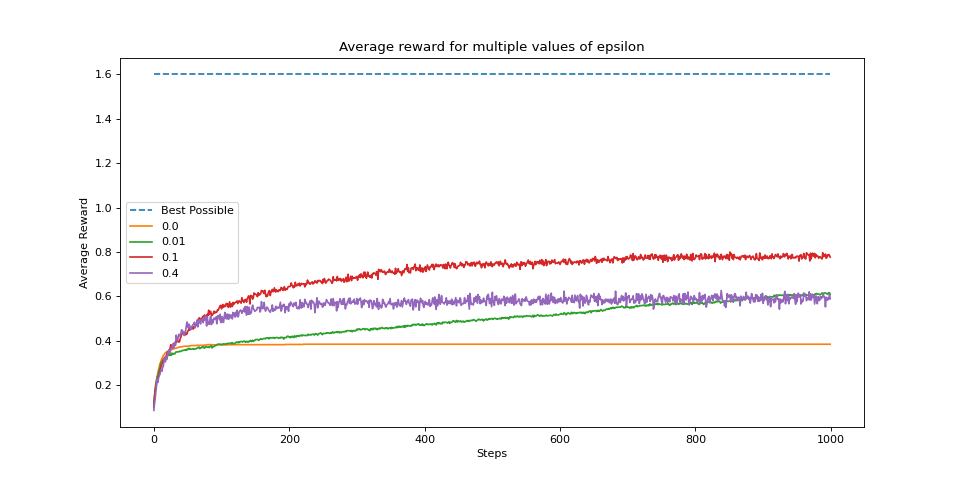

In [28]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') # why 1.6?


for epsilon in epsilons:
    _, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon)

    plt.plot(_)

plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

Here, we're plotting the average amount of reward received by the agent. This is because plotting the optimality on this many tests gets too crowded and noisy. As can be seen, the agent with an epsilon of `0.1` was the one that received the most amount of reward. Values of epsilon that are too small take very few exploratory actions, and therefore take a long time to explore and find the most optimal value. On the other hand, values of `epsilon` too high will obstruct the capacity of the agent of acting optimally. Too much exploration gets in the way of exploitation.

# Advanced strategies

Now that we have familiarized ourselves with the basic setup let us test a few more stratergies and see how they compare to the greedy and the epsilon greedy agent stratergies.

### Time Varying $\epsilon$-Greedy Algorithm

Create an agent that implements the Time Verying $\epsilon$-Greedy strategy. Implement using two parameters, one for the starting value of $\epsilon=\epsilon_0$ and other for the decay rate linear/exponential. Starting with the value of $\epsilon_0=1$ for epsilon and decay it linearly/exponentially to a very small value. The type of decay and the starting value of epsilon are input parameters to the function, include these in the function definition.

linear rate $\epsilon = \epsilon_0(1-t/T)$ <br />
exponential rate $\epsilon = \epsilon_0t^{-1/3}$

### Time Varying $\epsilon$-Greedy Agent

An agent class that executes the Time Varying $\epsilon$-Greedy Algorithm.

In [29]:
def linear_decay():
    return 0

def exp_decay():
    return 1

# Desired Agent class implementation
class TimeVaryingEpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, e_o, decay_type, num_steps):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        self.e_o = e_o
        self.decay_type = decay_type
        self.num_steps = num_steps

    def get_action(self, g, decay_type):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        if(decay_type==0):
            epsilon = self.e_o*(1-(g/self.num_steps))
        else:
            epsilon = self.e_o*(g**(-1/3))
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)

        self.action_count[np.arange(self.num_experiments), action] += 1

        return action

### Testing the agent

Observing how this Time varying $\epsilon$-greedy Agent behaves on the environment for linear decay case with $\epsilon_0 = 1$.

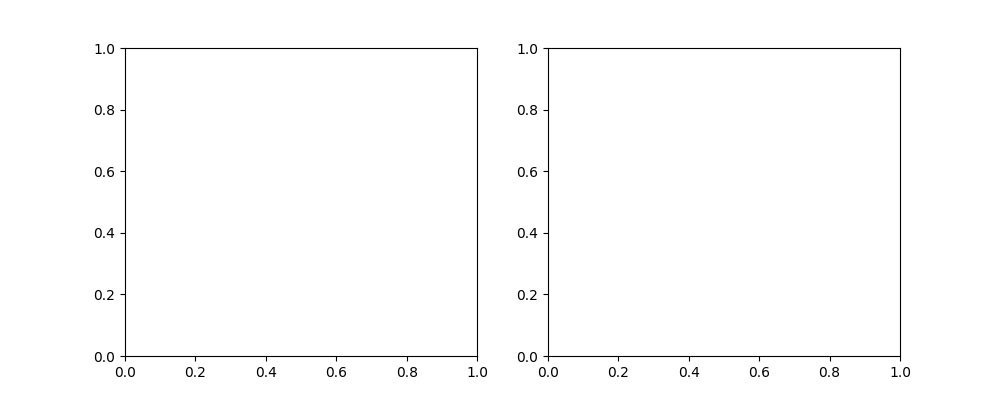

In [33]:
# Code for testing the Time varying epsilon greedy agent
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 1, linear_decay(), num_steps)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)


def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action(g, linear_decay())
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=False, blit=True)
plt.show()
anim.save('time-varying-epsilon-greedy-agent.gif', writer='pillow', fps=60)

In [34]:
def run_experiment(num_experiments=1000, num_steps=1000, num_bandits=10, e_o=1, type=linear_decay()):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), e_o, linear_decay(), num_steps)

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))

    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)

    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action(i, linear_decay())
        _, reward, _, _ = env.step(action)

        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)

        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score

        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:05<00:00, 174.13it/s]


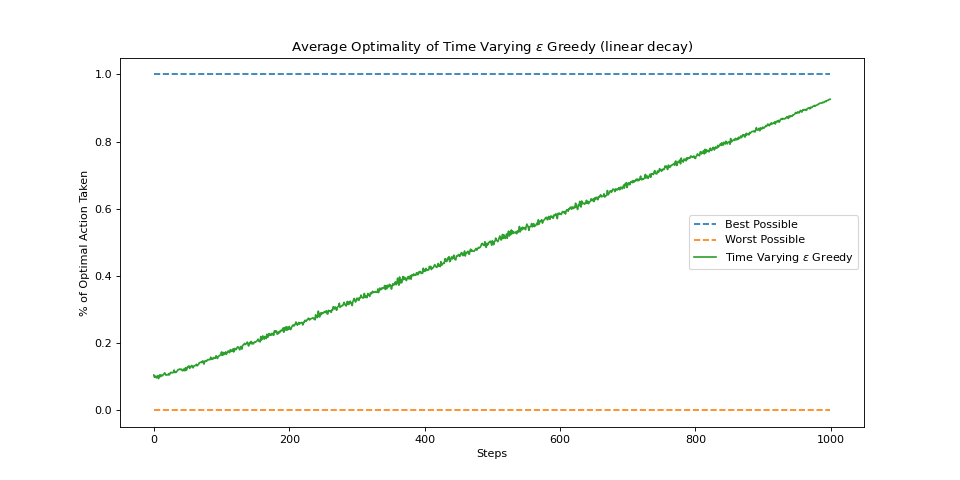

In [38]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
e_o = 1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, e_o)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.legend(["Best Possible", "Worst Possible", "Time Varying $\epsilon$ Greedy"])
plt.title("Average Optimality of Time Varying $\epsilon$ Greedy (linear decay)")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

### Experimenting with parameters

Designing and testing using an experiment using different values for $\epsilon_0 \in$ `{0 0.01 0.1 0.5 1}` along with linear and exponential decay scheme.

**Average Optimality Plots for Linear Decay and Exponential decay**

100%|██████████| 1000/1000 [00:07<00:00, 128.99it/s]


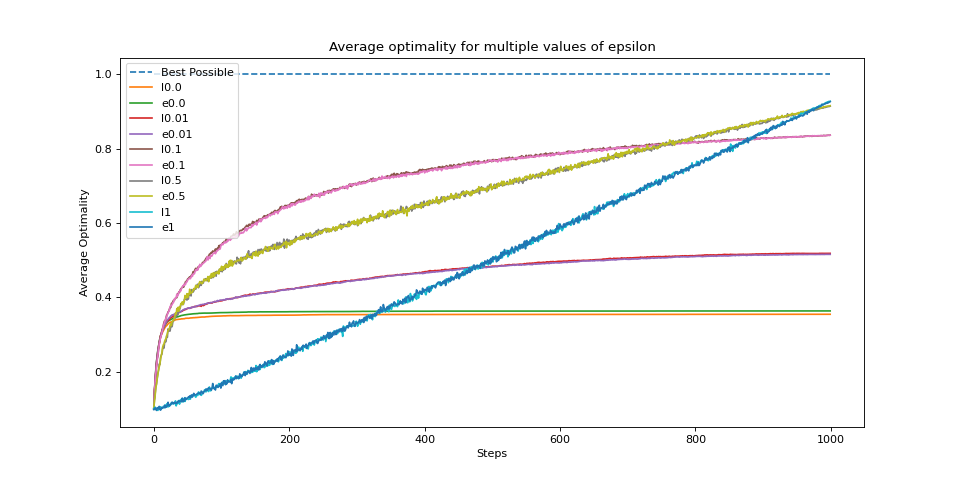

In [40]:
# Code for the experiment to test different values of parameters for Time varying epsilon-greedy agent
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilons_o = np.array([0.0, 0.01, 0.1, 0.5, 1])
eps = ['l0.0', 'e0.0', 'l0.01', 'e0.01', 'l0.1', 'e0.1', 'l0.5', 'e0.5', 'l1', 'e1']

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--') # why 1.6?

for e_o in epsilons_o:
    optimality_linear, reward = run_experiment(num_experiments, num_steps, num_actions, e_o, linear_decay())
    optimality_exponential, reward = run_experiment(num_experiments, num_steps, num_actions, e_o, exp_decay())

    plt.plot(optimality_linear)
    plt.plot(optimality_exponential)

plt.legend(["Best Possible"] + eps)
plt.title("Average optimality for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Optimality")
plt.show()

**Average Reward Plots for Linear decay and Exponential Decay**

100%|██████████| 1000/1000 [00:06<00:00, 162.28it/s]


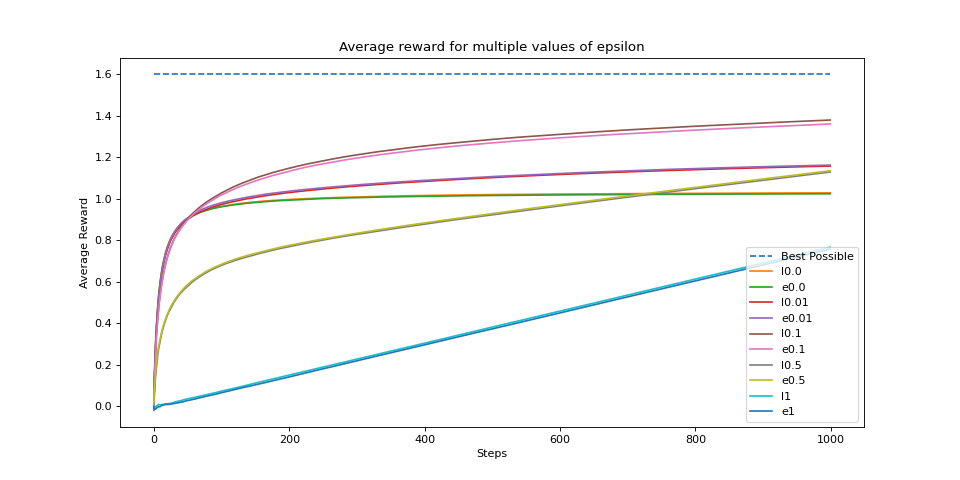

In [42]:
eps = ['l0.0', 'e0.0', 'l0.01', 'e0.01', 'l0.1', 'e0.1', 'l0.5', 'e0.5', 'l1', 'e1']

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')

for e_o in epsilons_o:
    optimality_linear, reward_linear = run_experiment(num_experiments, num_steps, num_actions, e_o, linear_decay())
    optimality_exponential, reward_exponential = run_experiment(num_experiments, num_steps, num_actions, e_o, exp_decay())

    plt.plot(reward_linear)
    plt.plot(reward_exponential)

plt.legend(["Best Possible"] + eps)
plt.title("Average reward for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

## The Upper-Confidence-Bound (UCB) Algorithm

The greedy actions are those that look best at present, but some of the other actions may actually be better. epsilon-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates.

### UCB Agent

An agent class that executes the UCB Algorithm.

$UCB_t = \mu_t + c \cdot \sqrt{\frac{\log T}{n_t(a)}}$

In [74]:
# UCB Agent implementation
class UCB(GreedyAgent):
    def __init__(self, reward_estimates, c, num_steps):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        self.c = c
        self.num_steps = num_steps

    def get_action(self,g):
        ucb = np.zeros((self.num_experiments, self.num_bandits))
        if(g < self.num_bandits):
            action = int(g)*np.ones((self.num_experiments,), dtype = int)
        else:
            for i in range(self.num_bandits):
              if(self.action_count[np.arange(self.num_experiments), i].any()>0):
                ucb[:,i] = (self.reward_estimates[:,i] + self.c * np.sqrt(np.log(self.num_steps)/self.action_count[np.arange(self.num_experiments), i]))

            action = argmax(ucb)

        self.action_count[np.arange(self.num_experiments), action] += 1

        return action

## Testing the agent

Observing how this UCB Agent behaves on the environment for a fixed value of parameter `c = 1`.

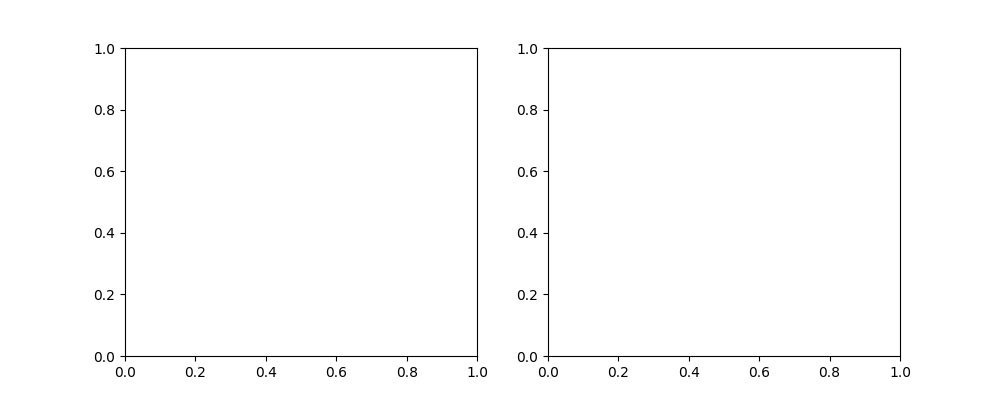

In [75]:
# Write your code for testing the UCB agent
# Write your code for testing the SEA agent
# Write your code for testing the Time varying epsilon greedy agent
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = UCB(np.zeros((num_experiments,num_bandits)), 1, num_steps)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)


def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action(g)
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=False, blit=True)
plt.show()
anim.save('UCB.gif', writer='pillow', fps=60)

## Values for weight parameter `c`

Designing and testing using an experiment using different values for `c` in `{0 1 2 3 4}`

In [68]:
# Code for the experiment to test different values of weight parameters
def run_experiment(num_experiments=1000, num_steps=1000, num_bandits=10, c=1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = UCB(np.zeros((num_experiments,num_bandits)), c, num_steps)

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))

    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)

    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action(i)
        _, reward, _, _ = env.step(action)

        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)

        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score

        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:07<00:00, 140.48it/s]


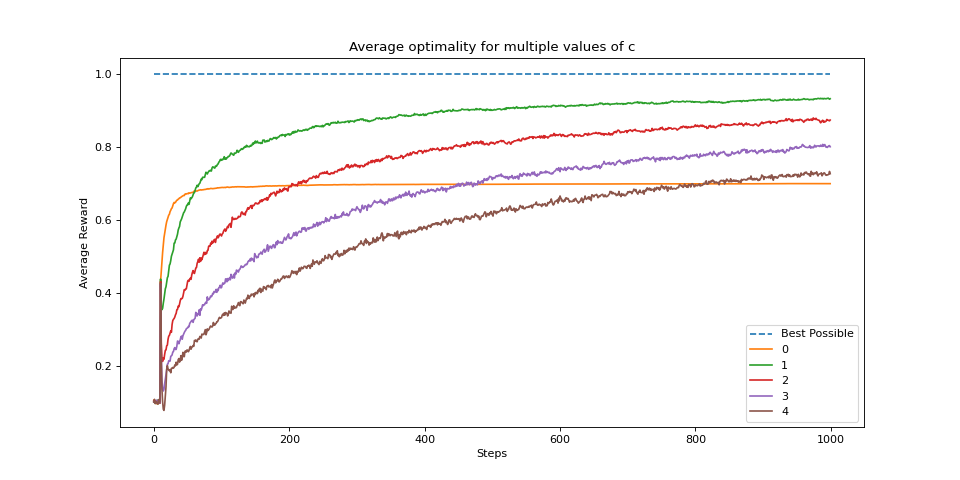

In [69]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
c_values = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--')

for c in c_values:
    optimality, reward = run_experiment(num_experiments, num_steps, num_actions, c)

    plt.plot(optimality)

plt.legend(["Best Possible"] + c_values.tolist())
plt.title("Average optimality for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

100%|██████████| 1000/1000 [00:07<00:00, 136.26it/s]


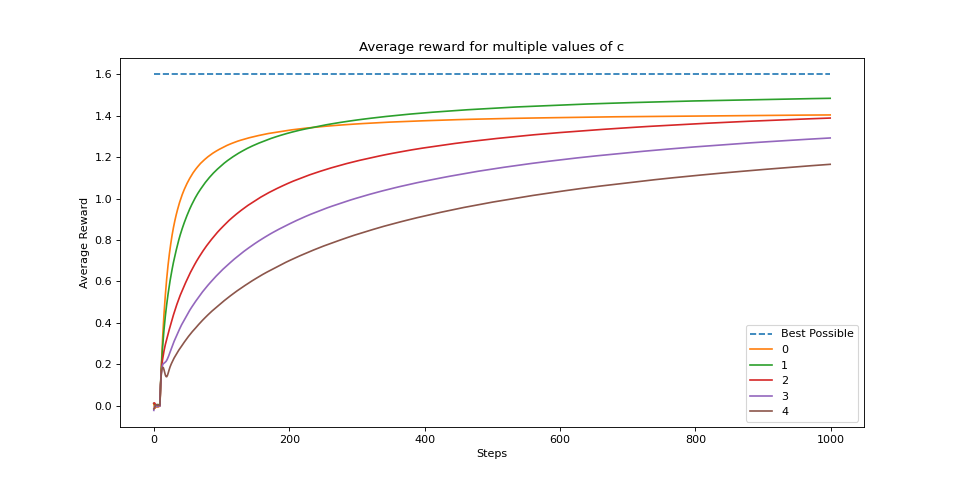

In [70]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
c_values = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')

for c in c_values:
    optimality, reward = run_experiment(num_experiments, num_steps, num_actions, c)

    plt.plot(reward)

plt.legend(["Best Possible"] + c_values.tolist())
plt.title("Average reward for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

## Regret Plots and Comparison

`Regret` is $R(T) = \sum_{t=1}^T [\mu^* - \mu(a_t)]$. It represents how much the algorithm 'regrets' not knowing the best arm in advance.

### Regret Plots

Till now we have explored multiple learning strategies to solve the MAB problem. The code used below is used to plot the average regret over 10000 experiments for the best cases (the case that reaches the highest optiimality action ratio) of all the above algorithms.

In [79]:
def run_experiment(valid_actions, num_experiments=1000, num_steps=1000, num_bandits=10, epsilon=0.1, e_o = 1,decay_type=exp_decay(), c_ucb = 1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_bandits)
    # Initialize the agent
    greedy_agent = GreedyAgent(np.zeros((num_experiments, num_bandits)))
    epsilon_greedy_agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_bandits)),epsilon)
    time_epsilon_agent = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments, num_bandits)), e_o, decay_type, num_steps)
    ucb_agent = UCB(np.zeros((num_experiments, num_bandits)), c_ucb, num_steps)
    # Store the scores and averages for later plotting
    regret_averages = np.zeros((4,num_steps))
    # optimality = np.zeros((num_steps))
    regretscores = np.zeros((4,num_experiments, num_steps+1))

    # Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)

    for i in range(1,num_steps):
        # Select an action to execute on the environment
        greedy_action = greedy_agent.get_action()
        epsilon_greedy_action = epsilon_greedy_agent.get_action()
        time_epsilon_action = time_epsilon_agent.get_action(i,decay_type)
        ucb_action = ucb_agent.get_action(i)

        _, greedy_reward, _, _ = env.step(greedy_action)
        _, epsilon_greedy_reward, _, _ = env.step(epsilon_greedy_action)
        _, time_epsilon_reward, _, _ = env.step(time_epsilon_action)
        _, ucb_reward, _, _ = env.step(ucb_action)


        # Update the agent estimates with the previously observed rewards
        greedy_agent.update_estimates(greedy_reward, greedy_action)
        epsilon_greedy_agent.update_estimates(epsilon_greedy_reward,epsilon_greedy_action)
        time_epsilon_agent.update_estimates(time_epsilon_reward,time_epsilon_action)
        ucb_agent.update_estimates(ucb_reward,ucb_action)

        # Store the average cumulative score and optimality of the current step
        regretscores[0,:,i+1] = regretscores[0,:,i] + env.mean[np.arange(num_experiments),optimal] - greedy_reward
        regretscores[1,:,i+1] = regretscores[1,:,i] + env.mean[np.arange(num_experiments),optimal] - epsilon_greedy_reward
        regretscores[2,:,i+1] = regretscores[2,:,i] + env.mean[np.arange(num_experiments),optimal] - time_epsilon_reward
        regretscores[3,:,i+1] = regretscores[3,:,i] + env.mean[np.arange(num_experiments),optimal] - ucb_reward

        # avg_score = np.mean(scores[:,i+1]/(i+1))
        # averages[i] = avg_score
        regret_averages[0,i]=np.sum(regretscores[0,:,i+1])/num_experiments
        regret_averages[1,i]=np.sum(regretscores[1,:,i+1])/num_experiments
        regret_averages[2,i]=np.sum(regretscores[2,:,i+1])/num_experiments
        regret_averages[3,i]=np.sum(regretscores[3,:,i+1])/num_experiments
    return regret_averages

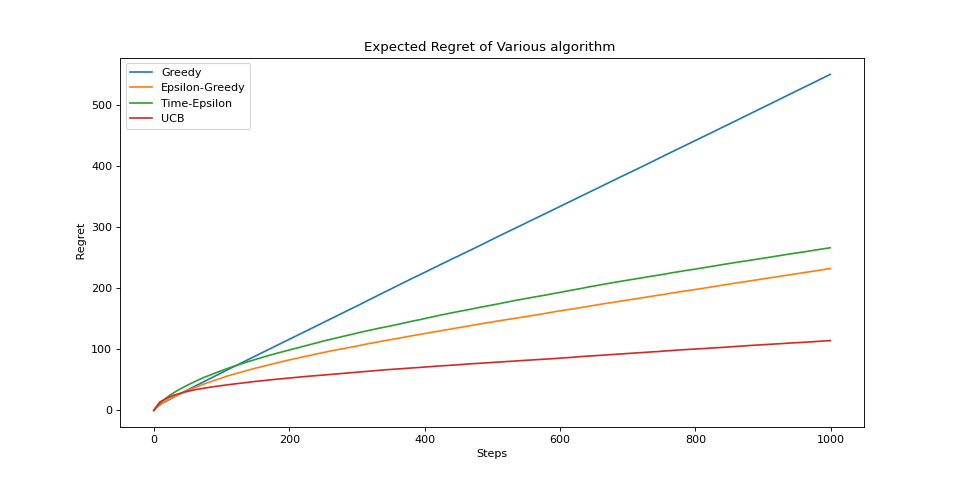

In [80]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilon = 0.1
e_t = 1
decay = exp_decay
c_sea = 2
c_ucb = 1
valid_actions = []
for i in range(num_experiments):
    valid_actions.append(np.arange(num_actions))

regret_average = run_experiment(valid_actions, num_experiments, num_steps, num_actions, epsilon, e_t, decay, c_ucb)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
# plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
# plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
for i in range(4):
    plt.plot(regret_average[i])

plt.legend(['Greedy', 'Epsilon-Greedy', 'Time-Epsilon', 'UCB'])
plt.title("Expected Regret of Various algorithm ")
plt.ylabel(" Regret")
plt.xlabel("Steps")
plt.show()